# Imports

In [141]:
# Data Handling
import pandas as pd
import numpy as np
import yfinance as yf

# Statistical Analysis
from scipy.stats import norm, skew, kurtosis
import arch

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prices and Returns

In [142]:
ticker = 'QQQ'

# METHOD 1: Download historical data for a specified ticker
# data = yf.download(ticker, start='2010-01-01', end='2023-10-01')

# METHOD 2: Download historical data for the last relevant periods
period = '15y'
data = yf.download(ticker, period=period)

data

/var/folders/j3/hjjq_tsd7kjd28d5plpk6lkh0000gn/T/ipykernel_48610/1123133217.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2010-06-24,39.669846,40.229687,39.538635,40.107220,114145900
2010-06-25,39.677742,40.019564,39.397272,39.888093,88740300
2010-06-28,39.537510,39.923155,39.274570,39.677745,71350000
2010-06-29,38.012474,38.967826,37.749534,38.932766,136384200
2010-06-30,37.433983,38.275392,37.372630,37.889747,101313200
...,...,...,...,...,...
2025-06-16,534.289978,535.369995,530.450012,530.500000,37622100
2025-06-17,529.080017,533.330017,527.909973,531.710022,42180900


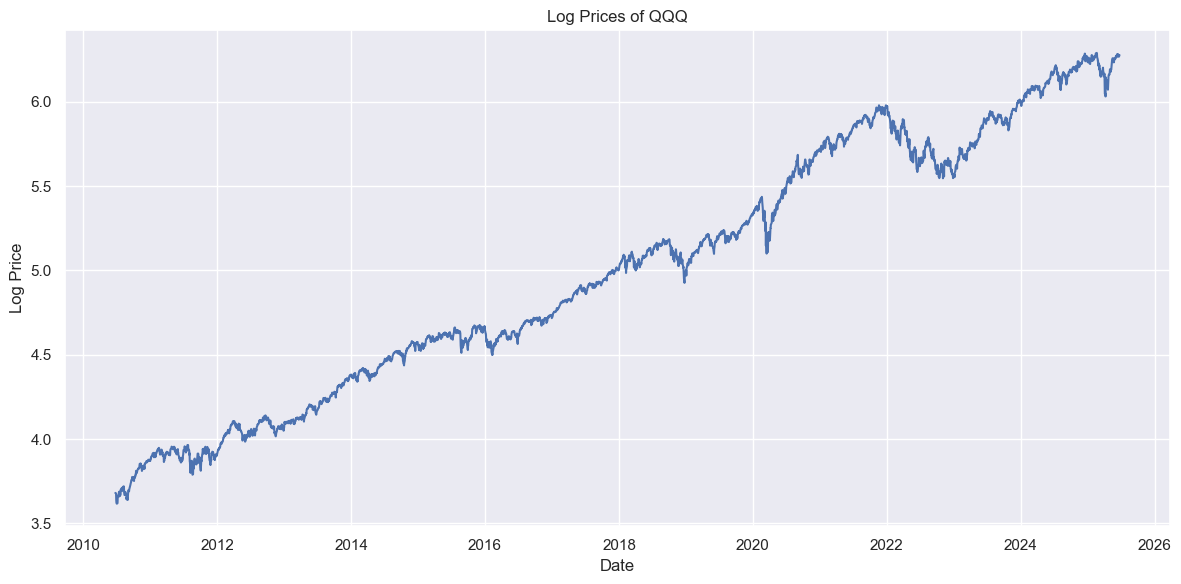

In [143]:
# Get the closing prices and compute log prices
prices = data['Close']
log_prices = np.log(prices)

# Plot the log prices
def plot_prices(prices, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(prices)
    plt.title(f'Log Prices of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.tight_layout()
    plt.show()
    
plot_prices(log_prices, ticker)

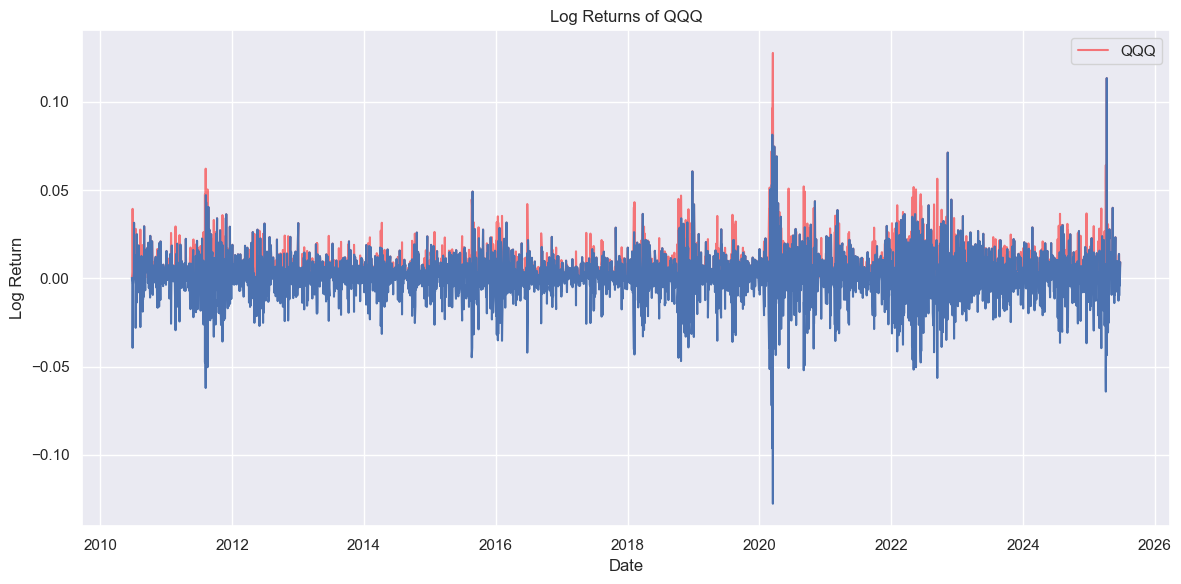

In [144]:
# Compute log returns
returns = log_prices.diff().dropna()

def plot_returns(returns, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(abs(returns), color='red', alpha=0.5, label='Absolute Returns')
    plt.plot(returns, label='Log Returns')
    plt.title(f'Log Returns of {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend(returns.columns)
    plt.tight_layout()
    plt.show()
    
plot_returns(returns, ticker)

# Non-Gaussianity

Distribution Analysis for QQQ
Mean: 0.0007
Standard Deviation: 0.013116
Skewness: -0.3933
Excess Kurtosis: 7.6245


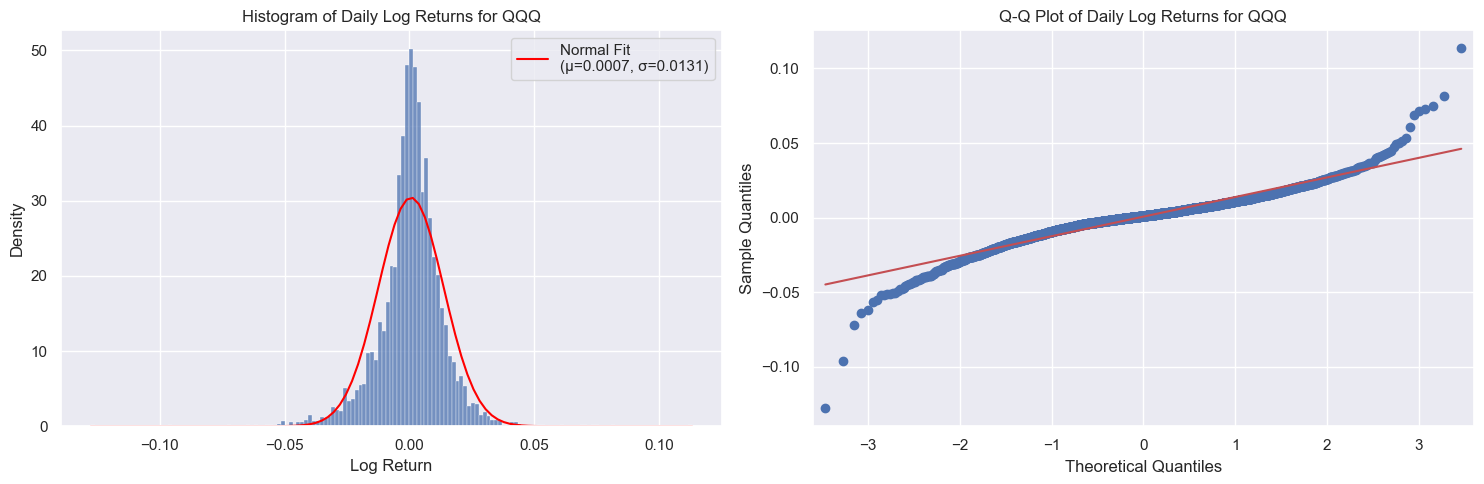

In [145]:
def analyse_distribution(returns, ticker):
    print(f'Distribution Analysis for {ticker}')
    print(f'Mean: {returns.mean():.4f}')
    print(f'Standard Deviation: {returns.std():4f}')
    print(f'Skewness: {skew(returns):.4f}')
    print(f'Excess Kurtosis: {kurtosis(returns, fisher=True):.4f}') # fisher=True for excess kurtosis
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Plot histogram and normal distribution fit (based on sample mean and std)
    sns.histplot(returns, kde=False, ax=ax[0], stat='density')
    x = np.linspace(returns.min(), returns.max(), 100)
    ax[0].plot(x, norm.pdf(x, returns.mean(), returns.std()), label=f'Normal Fit \n(μ={returns.mean():.4f}, σ={returns.std():.4f})', color='red')
    ax[0].set_title(f'Histogram of Daily Log Returns for {ticker}')
    ax[0].set_xlabel('Log Return')
    ax[0].set_ylabel('Density')
    ax[0].legend()
    
    # Plot Q-Q plot
    sm.qqplot(returns, line='s', ax=ax[1])
    ax[1].set_title(f'Q-Q Plot of Daily Log Returns for {ticker}')
    plt.tight_layout()
    plt.tight_layout()
    plt.show()
    
analyse_distribution(returns[ticker], ticker)

# Temporal Structure

## Linear Structure (autocorrelation)

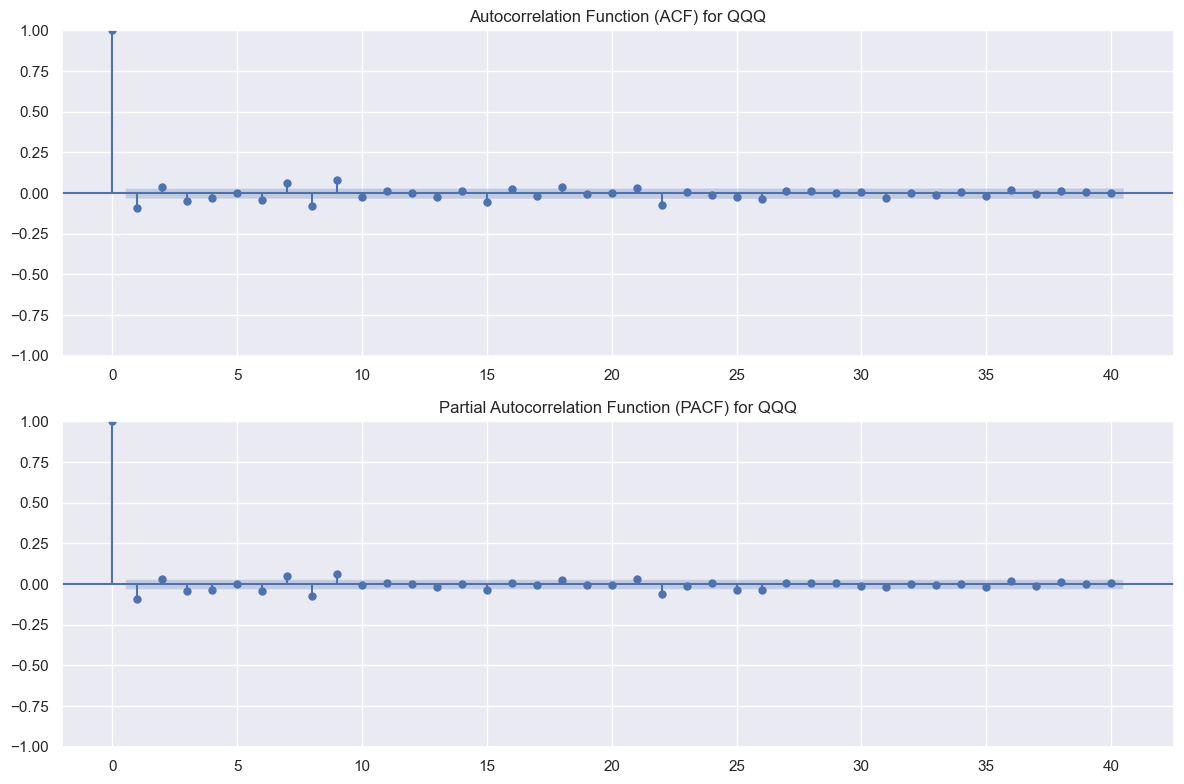

In [146]:
def plot_autocorrelation(returns, ticker):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot ACF
    plot_acf(returns[ticker], lags=40, ax=ax[0])
    ax[0].set_title(f'Autocorrelation Function (ACF) for {ticker}')
    
    # Plot PACF
    plot_pacf(returns[ticker], lags=40, ax=ax[1])
    ax[1].set_title(f'Partial Autocorrelation Function (PACF) for {ticker}')
    
    plt.tight_layout()
    plt.show()
    
plot_autocorrelation(returns, ticker)

## Nonlinear Structure

### Volatility Clustering

Volatility Estimation for QQQ


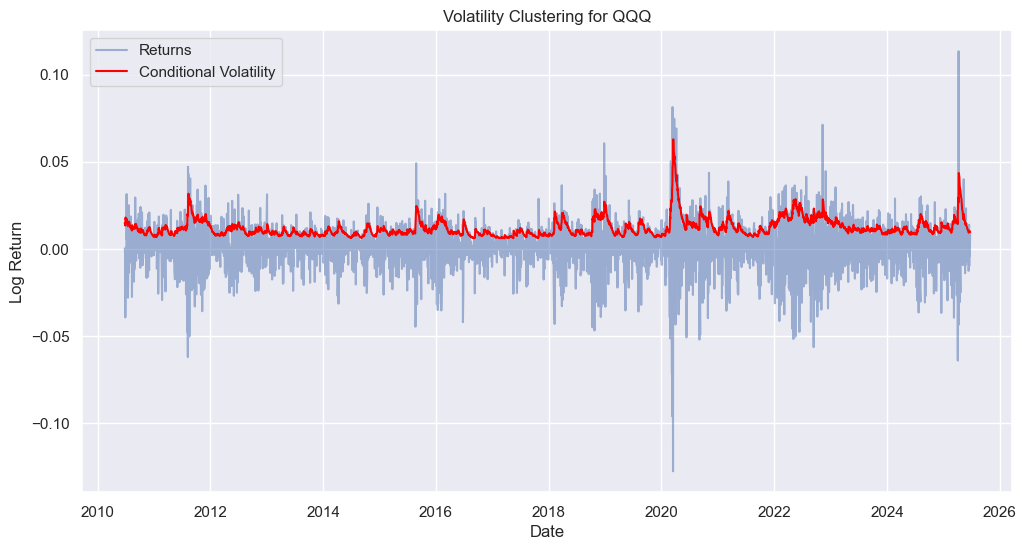

In [147]:
def estimate_volatility(returns, ticker):
    print(f'Volatility Estimation for {ticker}')
    
    # Fit GARCH model
    model = arch.arch_model(returns[ticker], vol='Garch', p=1, q=1, rescale='False')
    garch_fit = model.fit(disp='off')
    return garch_fit.conditional_volatility
    
def plot_volatility(returns, volatility, ticker):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(returns[ticker], alpha=0.5, label='Returns')
    ax.plot(volatility, color='red', label='Conditional Volatility')
    ax.set_title(f'Volatility Clustering for {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()
    plt.show()

volatility = estimate_volatility(returns, ticker)
plot_volatility(returns, volatility, ticker)

### Autocorrelation of Absolute Log-Returns

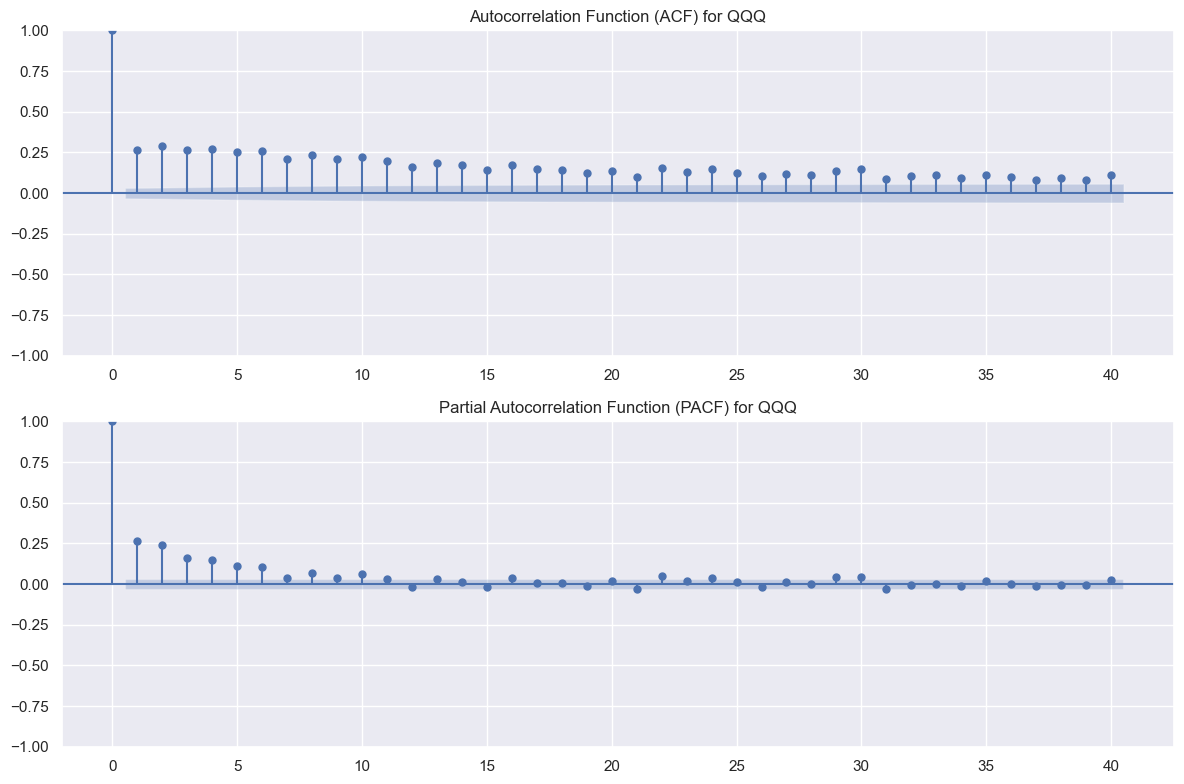

In [148]:
plot_autocorrelation(abs(returns), ticker)

# Asset Structure

In [149]:
# Get NASDAQ-100 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/NASDAQ-100"
tables = pd.read_html(url)
ticker_table = tables[4] # 5th table for NASDAQ-100 tickers

# Get ticker names
tickers = ticker_table['Ticker'].tolist()

# BRK.B becomes BRK-B for yfinance
tickers = [t.replace('.', '-') for t in tickers]

# Optionally, select a random sample of 50 tickers
# np.random.seed(42)  # for reproducibility
# n_sample_tickers = 50
# tickers = np.random.choice(tickers, size=n_sample_tickers, replace=False).tolist()
print(f"Selected Tickers ({len(tickers)}): {tickers}")

Selected Tickers (101): ['ADBE', 'AMD', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'APP', 'ARM', 'ASML', 'AZN', 'TEAM', 'ADSK', 'ADP', 'AXON', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LIN', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MSTR', 'MDLZ', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PLTR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SHOP', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL', 'ZS']


/var/folders/j3/hjjq_tsd7kjd28d5plpk6lkh0000gn/T/ipykernel_48610/346890537.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, period=period)['Close']
[*********************100%***********************]  101 of 101 completed

1 Failed download:
['GFS']: SSLError('Failed to perform, curl: (35) Recv failure: Connection reset by peer. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


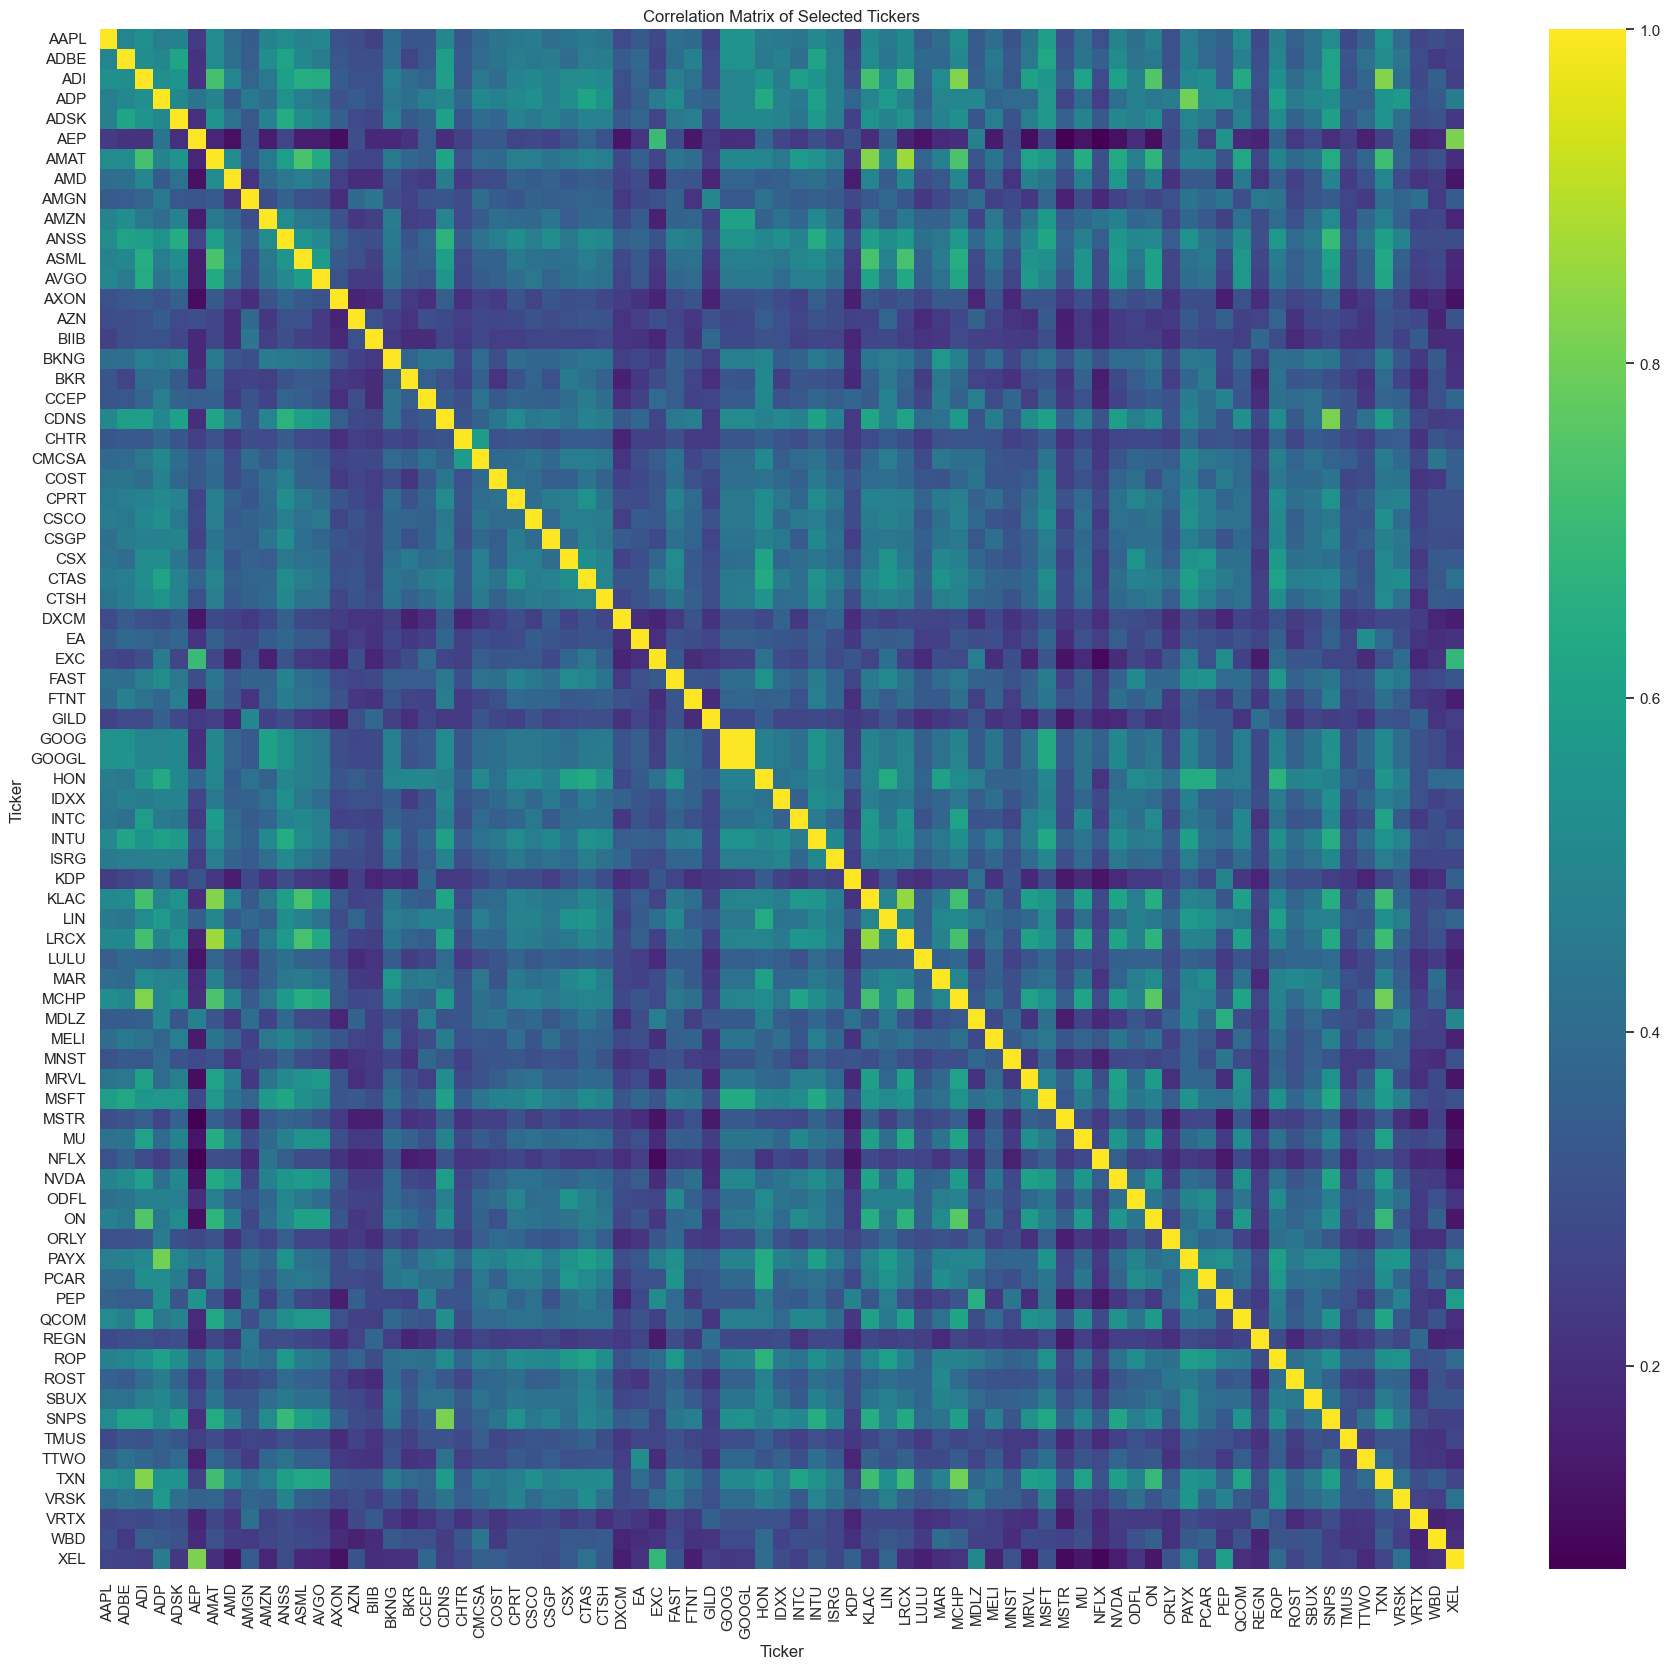

In [150]:
# Plot correlation matrix for the selected tickers
def get_multiple_tickers(tickers, period='15y'):
    prices = yf.download(tickers, period=period)['Close']
    
    # Ensure all tickers have data
    prices = prices.dropna(axis=1, how='any')
    
    # Compute log prices and log returns
    log_prices = np.log(prices)
    log_returns = log_prices.diff().dropna()
    return log_prices, log_returns


def plot_correlation_matrix(returns):
    # Compute correlation matrix
    corr_matrix = returns.corr()
    
    plt.figure(figsize=(22, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.title('Correlation Matrix of Selected Tickers')
    plt.show()

# Get log prices and log returns for multiple tickers (our universe)
log_prices_uni, log_returns_uni = get_multiple_tickers(tickers)
plot_correlation_matrix(log_returns_uni)

## Extra: Most Correlated Pairs

Total pairs found (corr. threshold: 0.8): 10


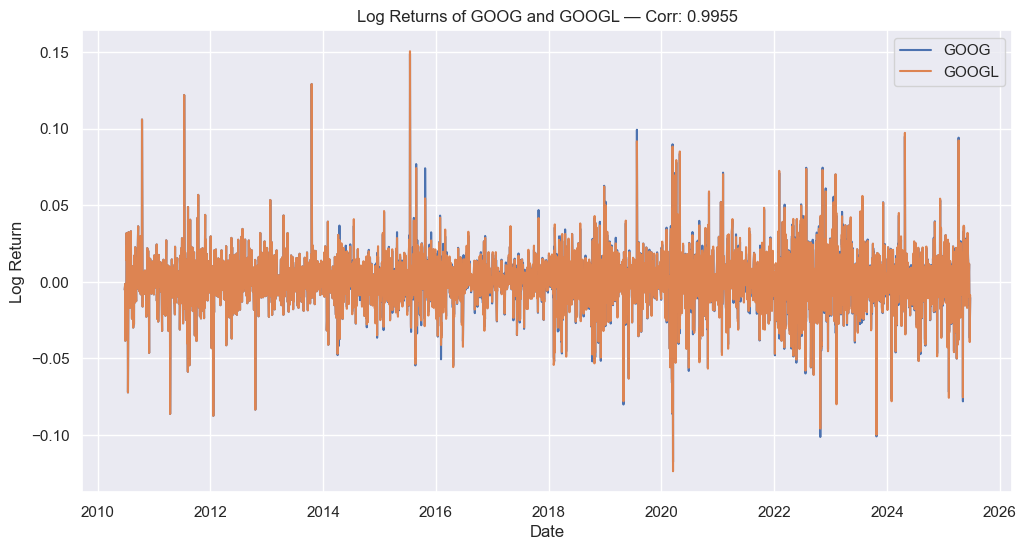

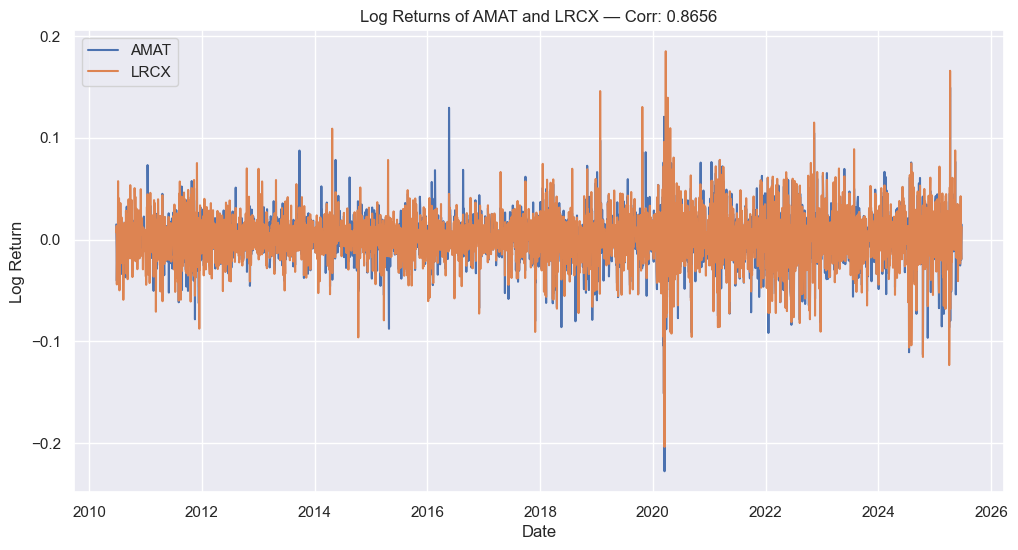

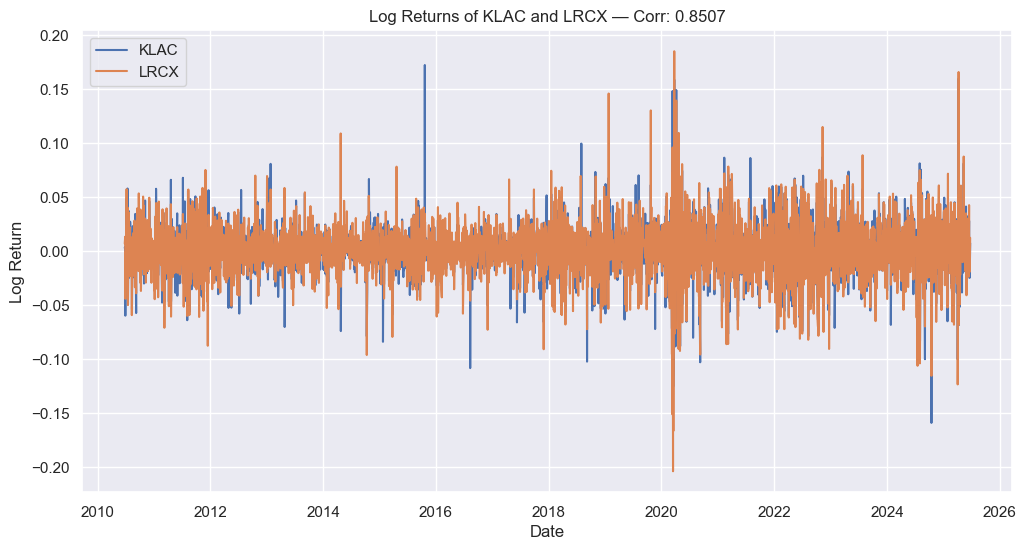

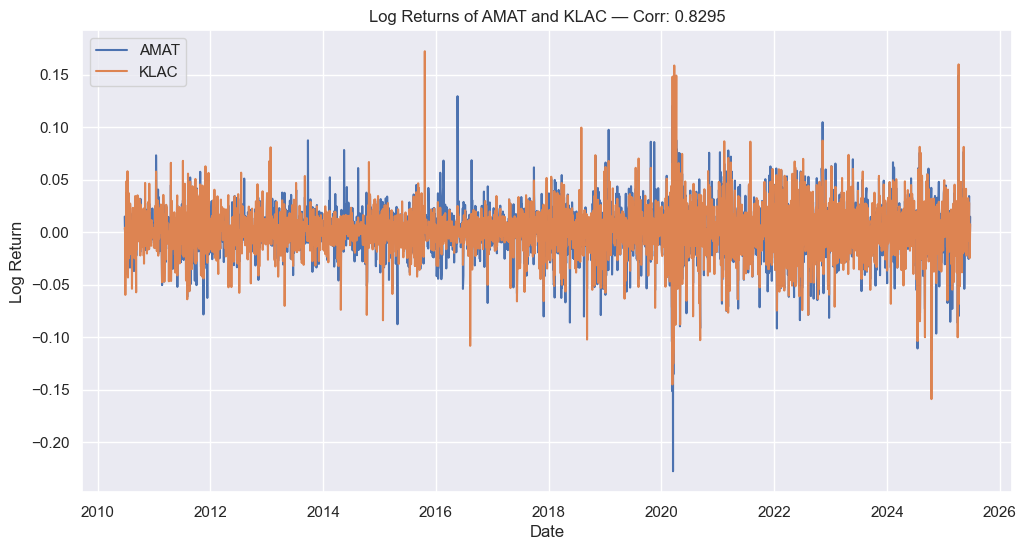

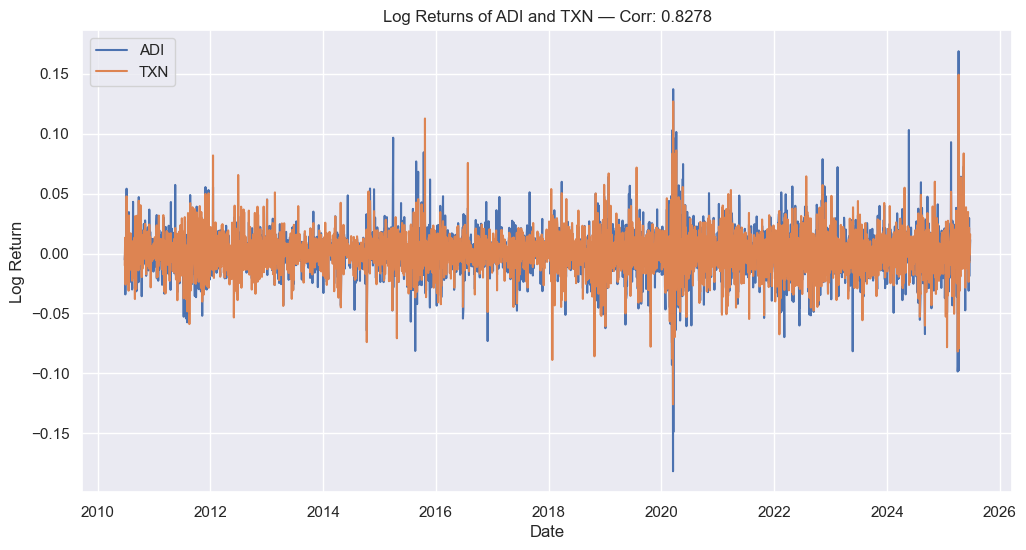

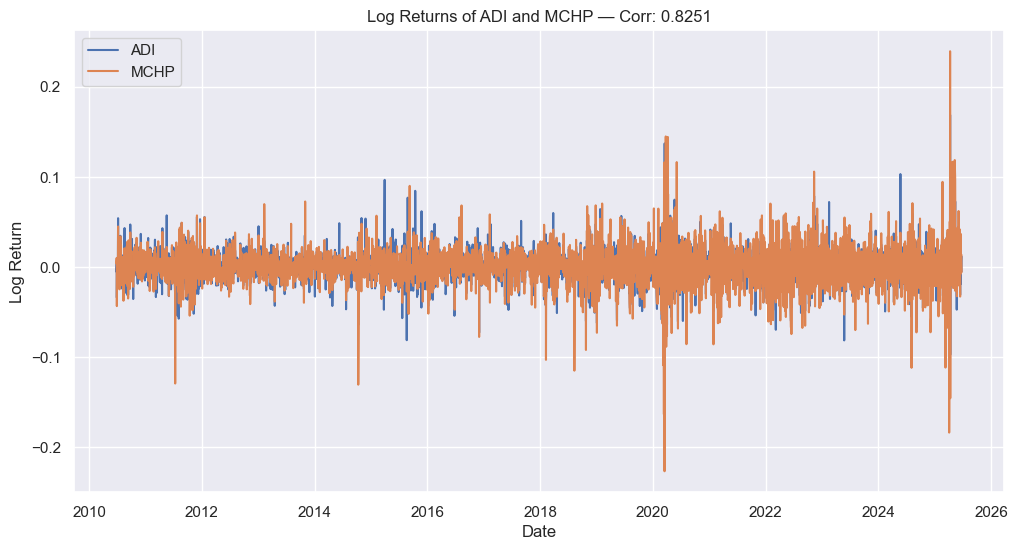

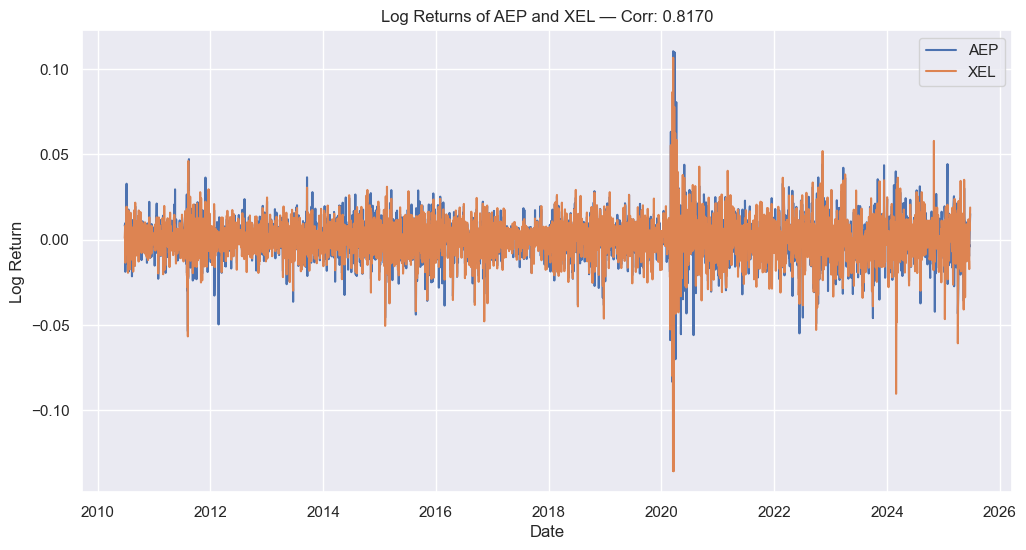

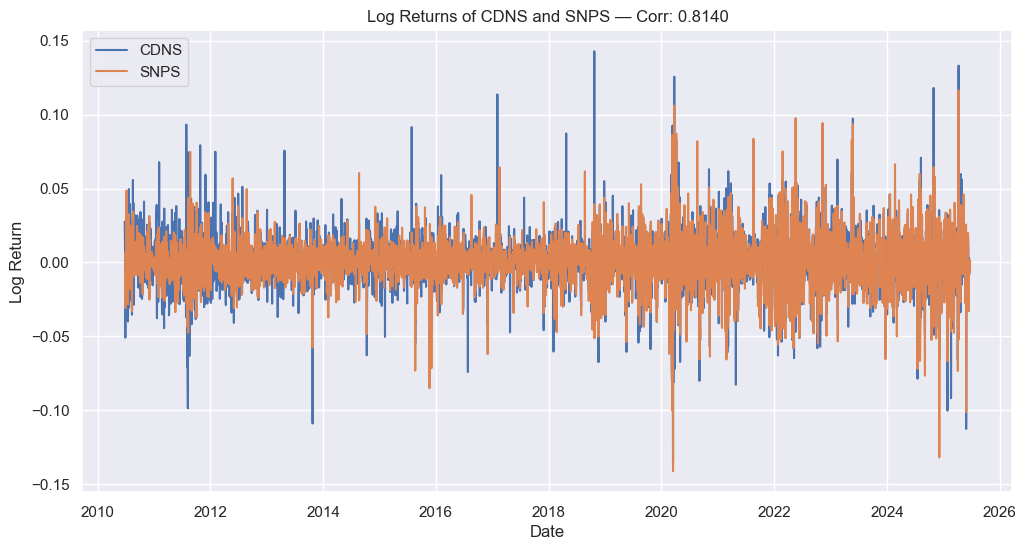

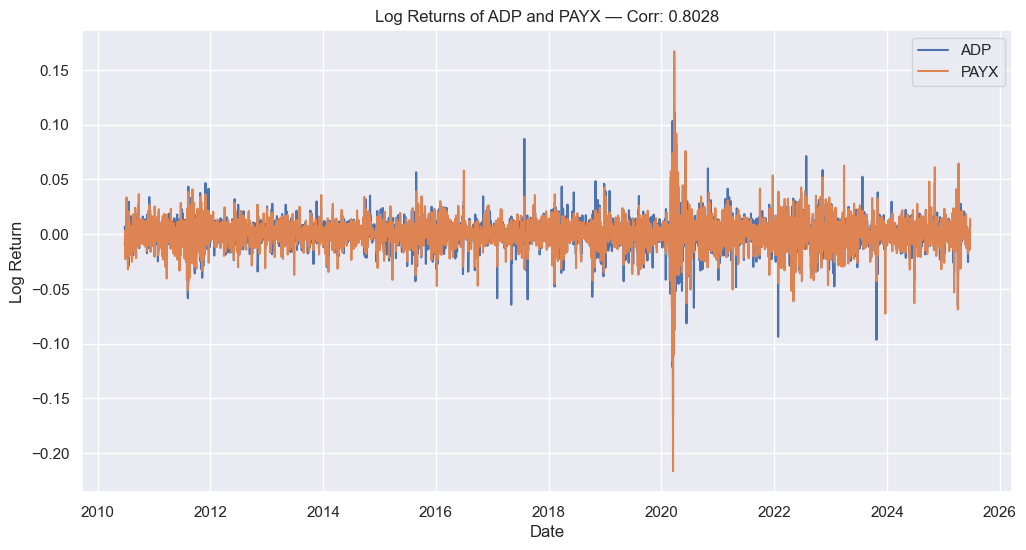

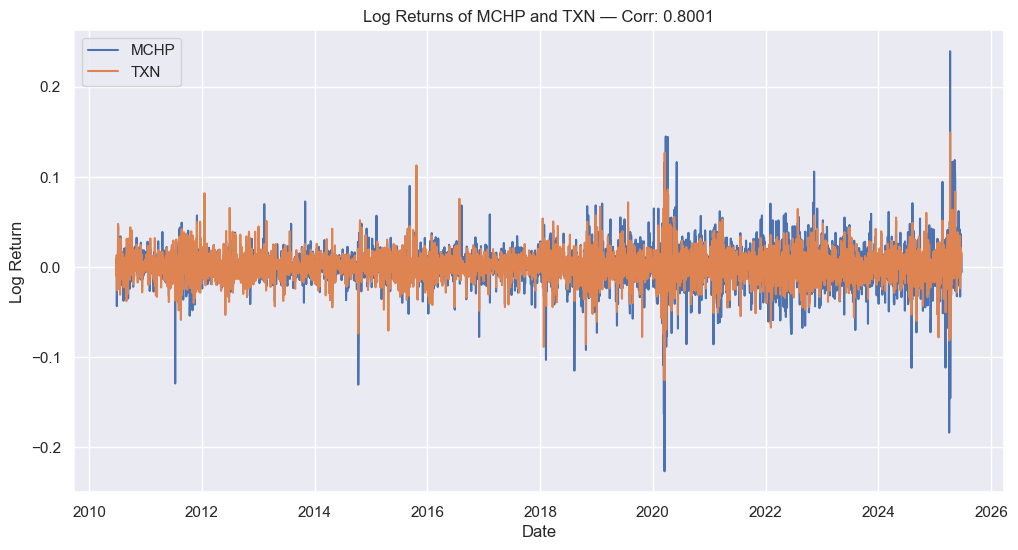

In [156]:
def plot_most_correlated_pairs(returns, corr_threshold=0.8):    
    # Compute correlation matrix
    corr_matrix = returns.corr()
    
    # Get the most correlated pairs
    corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
    corr_pairs = corr_pairs[corr_pairs < 1]  # Exclude self-correlations
    corr_pairs = corr_pairs[corr_pairs.index.map(lambda x: x[0] < x[1])] # Remove duplicates (e.g., (A, B) and (B, A))
    top_pairs = corr_pairs[corr_pairs > corr_threshold]
    
    print(f'Total pairs found (corr. threshold: {corr_threshold}): {len(top_pairs)}')
    for pair in top_pairs.index:
        plt.figure(figsize=(12, 6))
        plt.plot(returns[pair[0]], label=pair[0])
        plt.plot(returns[pair[1]], label=pair[1])
        plt.title(f'Log Returns of {pair[0]} and {pair[1]} — Corr: {top_pairs[pair]:.4f}')
        plt.xlabel('Date')
        plt.ylabel('Log Return')
        plt.legend()
        plt.show()
        
plot_most_correlated_pairs(log_returns_uni, corr_threshold=0.8)